# Adult Census Income dataset (Feedforward Neural Network)

### Objective:
The goal is to predict whether an individual's annual income exceeds $50K based on census data, commonly known as the **"Census Income"** dataset.

#### Dataset Details:
- **Features**: 14 (Categorical and Integer types)
- **Instances**: 48,842
- **Source**: Data extracted by Barry Becker from the 1994 Census database.
- **Link**: [Census Income Dataset](https://archive.ics.uci.edu/dataset/2/adult)


## 1. Data preparations

In [6]:
# Data Processing and Manipulation 
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Neural Networks
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Other Tools 
from ucimlrepo import fetch_ucirepo 
import time

In [7]:
# Prepare data

## fetch dataset 
adult = fetch_ucirepo(id=2) 
X = adult.data.features 
Y = adult.data.targets 

## Built dataFrame
df = pd.concat([X, Y], axis=1)

## Save orginal dataset
df_org = df.copy()

## 2. Data Analysis  

### 2.1. Generel overview of dataset

In [99]:
# Overview of indeptendent variable 
print("NA in independent variable: ", df["income"].isna().sum())
y_values_counts = df["income"].value_counts()
y_values_counts

NA in independent variable:  0


income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

In [12]:
# Correct values in dependent variable
df.loc[:, "income"] = Y["income"].apply(lambda x: 1 if ">" in str(x) else 0)
df["income"] = df["income"].astype(int)
# Check manipulation 
df["income"].value_counts()


income
0    37155
1    11687
Name: count, dtype: int64

In [16]:
# Overview of dataset

## Size 
amount_row = df.size
amount_cols = df.shape[1]
print(f"Columns: {amount_cols}    Rows: {amount_row}")


## Check for NA 
na_info = df.isna().sum()
col_na = na_info[na_info > 0]

print("Columns with missing values")
print(col_na)

## Display data 
summary = pd.DataFrame({
    "Type": df.dtypes,
    "First 5 Values": [df[col].head().tolist() for col in df.columns]
})

summary



Columns: 15    Rows: 732630
Columns with missing values
workclass         963
occupation        966
native-country    274
dtype: int64


,Type,First 5 Values
age,int64,"[39, 50, 38, 53, 28]"
workclass,object,"[State-gov, Self-emp-not-inc, Private, Private..."
fnlwgt,int64,"[77516, 83311, 215646, 234721, 338409]"
education,object,"[Bachelors, Bachelors, HS-grad, 11th, Bachelors]"
education-num,int64,"[13, 13, 9, 7, 13]"
marital-status,object,"[Never-married, Married-civ-spouse, Divorced, ..."
occupation,object,"[Adm-clerical, Exec-managerial, Handlers-clean..."
relationship,object,"[Not-in-family, Husband, Not-in-family, Husban..."
race,object,"[White, White, White, Black, Black]"
sex,object,"[Male, Male, Male, Male, Female]"


### 2.2. Overview of nummerical variable

In [18]:
# Filter only nummerical cols
df_num = df.select_dtypes(include= ["int64"])


# Developt fct for analysis 
def analyze_int64_variables(df):
    results = []  # List to store analysis results

    for col in df.columns:  # Iterate through each column
        
        # Calculate the top 5 most common values and their correct percentages
        total_count = len(df[col])  # Total number of rows for the column
        value_counts = df[col].value_counts().head(5)  # Top 5 most common values
        top_5_common = {f"{val}": f"{(freq / total_count) * 100:.2f}%" for val, 
                        freq in zip(value_counts.index, value_counts.values)}

        # Create dataframe with stats
        col_stats = {
            'Column': col,  # Add column name
            'Spread': (df[col].min(), df[col].max()),  # Minimum and maximum values
            'Unique Values': df[col].nunique(),  # Number of unique values
            'Top 5 Most Common': top_5_common,  # Top 5 most common values with percentages
            'Median': df[col].median(),  # Median value
        }
        results.append(col_stats)  # Append the stats for each column to the list

    # Convert the results into a DataFrame
    return pd.DataFrame(results)

# Application of function 
analyze_int64_variables(df_num)

,Column,Spread,Unique Values,Top 5 Most Common,Median
0,age,"(17, 90)",74,"{'36': '2.76%', '35': '2.74%', '33': '2.73%', ...",37.0
1,fnlwgt,"(12285, 1490400)",28523,"{'203488': '0.04%', '120277': '0.04%', '190290...",178144.5
2,education-num,"(1, 16)",16,"{'9': '32.32%', '10': '22.27%', '13': '16.43%'...",10.0
3,capital-gain,"(0, 99999)",123,"{'0': '91.74%', '15024': '1.05%', '7688': '0.8...",0.0
4,capital-loss,"(0, 4356)",99,"{'0': '95.33%', '1902': '0.62%', '1977': '0.52...",0.0
5,hours-per-week,"(1, 99)",96,"{'40': '46.69%', '50': '8.69%', '45': '5.56%',...",40.0
6,income,"(0, 1)",2,"{'0': '76.07%', '1': '23.93%'}",0.0


**Comment: Capital-gain and capital-loss each have two values that account for over 90% of the total.**

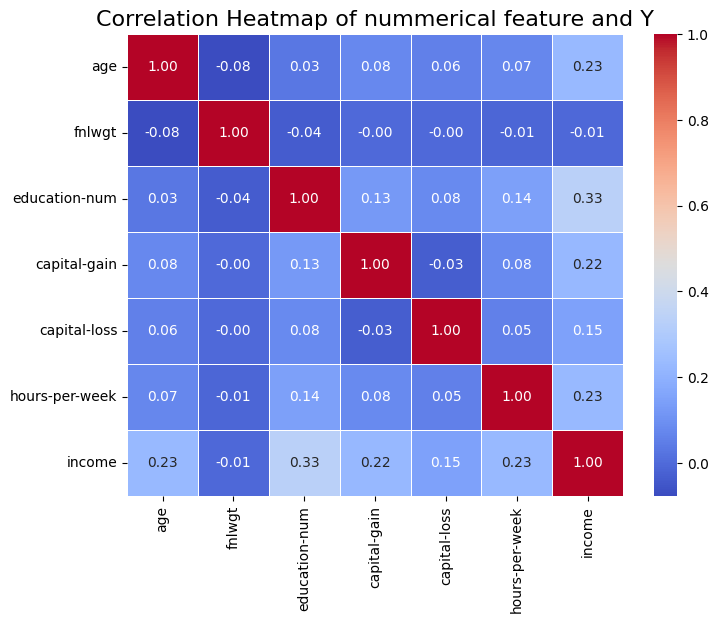

In [20]:
# Correlation heatmap for num features and dependent variable 
plt.figure(figsize=(8, 6))  # Adjust the figure size
sns.heatmap(df_num.corr(), cmap="coolwarm", annot=True, fmt=".2f", cbar=True, linewidths=0.5)
plt.title("Correlation Heatmap of nummerical feature and Y", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


**Comment: Fnlwgt appears to have extremely low explanatory power.**

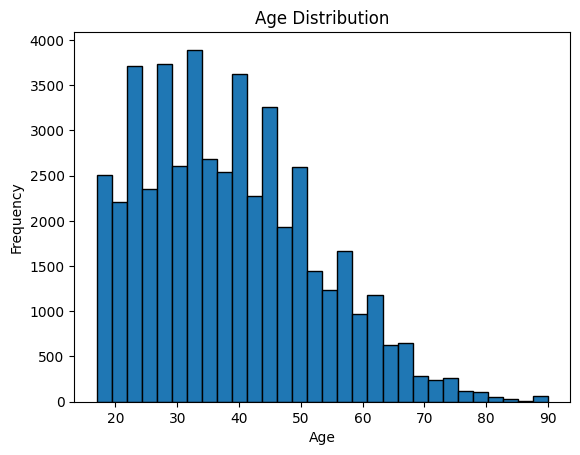

Amount of children: 2.983%
Number of children with income change: 0


In [22]:
# Variable: age

# Plot histogram for the age variable
plt.hist(df_num["age"], bins=30, edgecolor='k')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Get percentage of children
threshold = 19
amount_childreen = round((df_num["age"] < threshold).sum() / len(df_num) * 100, 3)

# Get the number of children with income (assuming Y = 1 represents income)
child_income = df_num[(df_num["age"] < threshold) & (df_num["income"] == 1)].shape[0]

# Print results
print(f"Amount of children: {amount_childreen}%")
print(f"Number of children with income change: {child_income}")

**Comment: Dropping individuals above 18 seems reasonable.**

### 2.3. Overview of categorical varibale

In [24]:
# Filter categorical ("object") columns
selected_columns = df.select_dtypes(include='object')

# Loop through each column and print unique values
for col in selected_columns.columns:
    print(f"Column: {col}")
    print("Unique Values:", df[col].unique())
    print("")
    print("-" * 50)


Column: workclass
Unique Values: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked' nan]

--------------------------------------------------
Column: education
Unique Values: ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']

--------------------------------------------------
Column: marital-status
Unique Values: ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']

--------------------------------------------------
Column: occupation
Unique Values: ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv' nan]

--------------------------------------------------

**Comment: "?" appears in some variables as representations of missing values**

In [26]:
# Replace np.nan and '?' with 'NA' in all columns of the dataset
df = df.replace("?", np.nan)


In [28]:
# Percentage of missing values in each column
missing_per_column = round((df.isna().sum() / len(df)) * 100, 3)

# Percentage of rows with at least one missing value
rows_with_na = round((df.isna().any(axis=1).sum() / len(df)) * 100, 3)

# Display the results
print("Percentage of missing values per column:")
print(missing_per_column)

print(f"\nPercentage of rows with at least one missing value: {rows_with_na:.2f}%")



Percentage of missing values per column:
age               0.000
workclass         5.731
fnlwgt            0.000
education         0.000
education-num     0.000
marital-status    0.000
occupation        5.751
relationship      0.000
race              0.000
sex               0.000
capital-gain      0.000
capital-loss      0.000
hours-per-week    0.000
native-country    1.755
income            0.000
dtype: float64

Percentage of rows with at least one missing value: 7.41%


In [30]:
# Filter common NA rows in workclass and occupation
workclass_na = df[df["workclass"].isna()]
workclass_and_occupation_na = workclass_na["occupation"].isna().sum()
percentage = (workclass_and_occupation_na / len(workclass_na)) * 100

# Display the results
print(f"Rows where 'workclass' is NA and 'occupation' is also NA: {workclass_and_occupation_na}")
print(f"Percentage of such rows: {percentage:.2f}%")

Rows where 'workclass' is NA and 'occupation' is also NA: 2799
Percentage of such rows: 100.00%


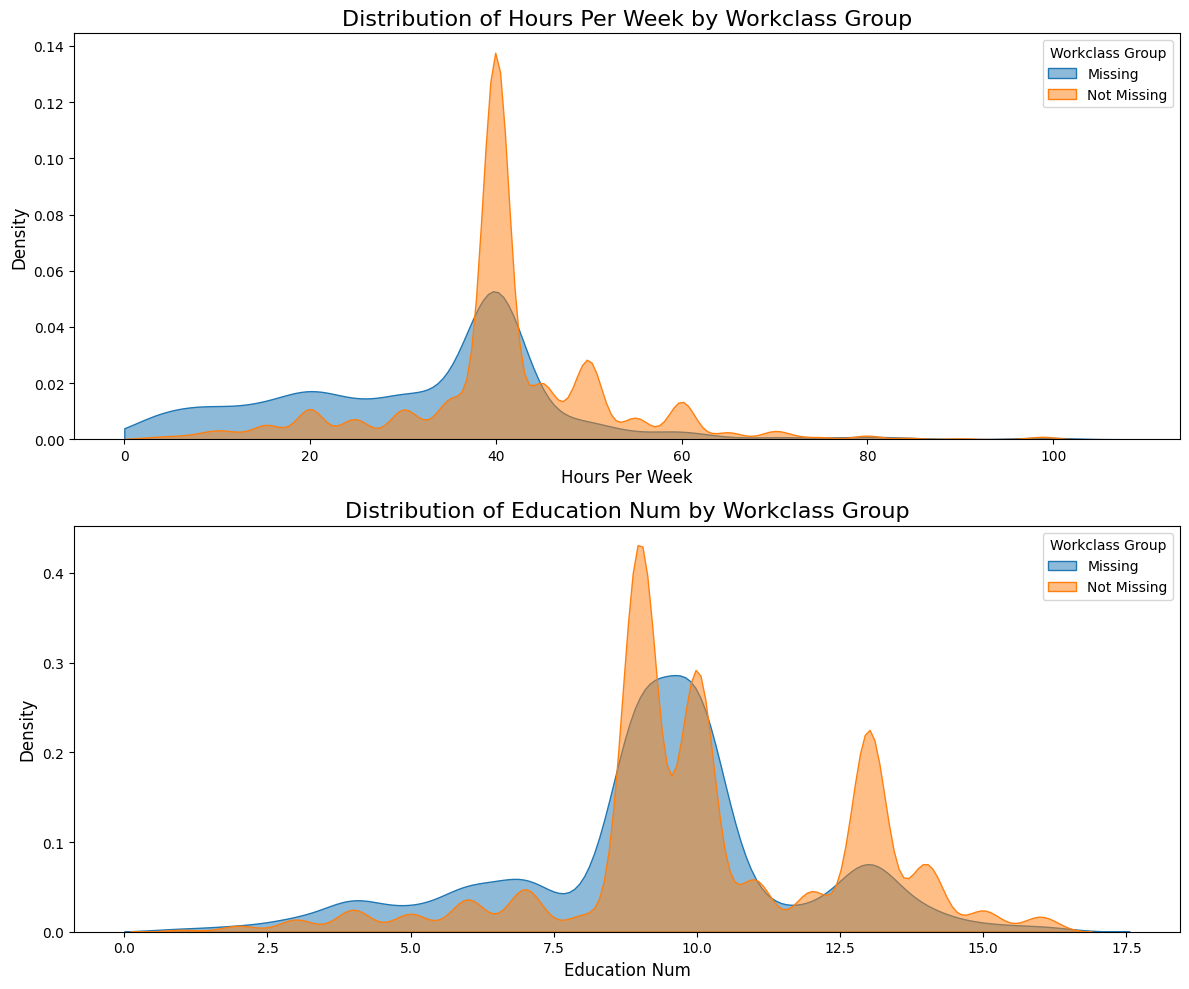

In [32]:
# Create a group based on whether 'workclass' is NaN
df['workclass_group'] = df['workclass'].isna().map({True: 'Missing', False: 'Not Missing'})

plt.figure(figsize=(12, 10))

# Subplot 1: KDE for 'hours-per-week'
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st plot
sns.kdeplot(
    df[df['workclass_group'] == 'Missing']['hours-per-week'], 
    label='Missing', fill=True, alpha=0.5, clip=(0, None)
)
sns.kdeplot(
    df[df['workclass_group'] == 'Not Missing']['hours-per-week'], 
    label='Not Missing', fill=True, alpha=0.5, clip=(0, None)
)
plt.title('Distribution of Hours Per Week by Workclass Group', fontsize=16)
plt.xlabel('Hours Per Week', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Workclass Group', fontsize=10)

# Subplot 2: KDE for 'education-num'
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd plot
sns.kdeplot(
    df[df['workclass_group'] == 'Missing']['education-num'], 
    label='Missing', fill=True, alpha=0.5, clip=(0, None)
)
sns.kdeplot(
    df[df['workclass_group'] == 'Not Missing']['education-num'], 
    label='Not Missing', fill=True, alpha=0.5, clip=(0, None)
)
plt.title('Distribution of Education Num by Workclass Group', fontsize=16)
plt.xlabel('Education Num', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Workclass Group', fontsize=10)

plt.tight_layout()
plt.show()


In [34]:
df = df.drop(columns = ["workclass_group"])

**Comment: There is a pattern associated with missing values in the occupation variable. To preserve these observations, we will employ a model-based imputation approach and create an indicator variable to save their meaning.**

In [37]:
# Variable: education & education-num 	

## Check unique combinations of var1 and var2
unique_pairs = df[["education-num", "education"]].drop_duplicates()

## Print unique combinations to verify the mapping
print("Unique pairs of var1 and var2:")
print(unique_pairs)

## Drop categorical edu var
X = X.drop(columns = ["education"])

Unique pairs of var1 and var2:
     education-num     education
0               13     Bachelors
2                9       HS-grad
3                7          11th
5               14       Masters
6                5           9th
10              10  Some-college
13              12    Assoc-acdm
14              11     Assoc-voc
15               4       7th-8th
20              16     Doctorate
52              15   Prof-school
56               3       5th-6th
77               6          10th
160              2       1st-4th
224              1     Preschool
415              8          12th


**Comment: education-num and education measure the exact same thing.**

## 3. Data Manipulation

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      46033 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  47985 non-null  object
 14  income          48842 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.6+ MB


1. **Drop Rows and Columns**
   - Remove observations where age is under 17.
   - Drop rows with missing values in the `native-country` column.
   - Remove the `education` column, as the same information is already present in the `education-num` column.

2. **Feature Enginering**
   - Create No-Capital-Gain and No-Capital-Loss variable
   - Create Contintent variables
   
3. **Transform Categorical Variables into Numerical Variables**
   - For the `sex` variable, map "Female" to 1 and "Male" to 0.
   - Apply one-hot encoding to the following categorical variables: `native-country`, `marital-status`, `race`, and `relationship`.

4. **Data Imputation**
   - Create binary variable for missing
   - Use Random Forest to impute missing values for the `workclass` column.
   - Use Random Forest to impute missing values for the `occupation` column.

5. **One-Hot Encoding for `workclass` and `occupation`**
   - Apply one-hot encoding to the `workclass` and `occupation` columns to convert them into binary columns.

6. **Final dataset preparations for machine learning**

In [41]:
# 1.Drop rows and columns 

## Dataframe before manipulation 
print("Before:", df.shape)
amount_row_before = df.shape[0]
# Drop childreen observation 
df = df[df["age"] > 17]

## Drop rows with missing in native country 
df = df.dropna(subset = ["native-country"])

## Drop var education delivers no new information 
df = df.drop(columns = ["education"])

## Dataframe afterwards
print("Afterwards:", df.shape)
amount_row_after = df.shape[0]
data_loss = round(1 - (amount_row_after/amount_row_before), 3)* 100
print(F"Total data loss: {data_loss} %") 

Before: (48842, 15)
Afterwards: (47393, 14)
Total data loss: 3.0 %


In [43]:
# 2. Feature Engineering 

## 2.1. capital-gain  capital-loss
df["no_capital_loss"] = np.where(df["capital-loss"] == 0, 1, 0)
df["no_captial_gain"] = np.where(df["capital-gain"] == 0, 1, 0)
                            

In [45]:
## 2.2 Contintent variables

## See cases
df["native-country"].unique()

# Define continent mapping
continent_mapping = {
    "North America": [
        'United-States', 'Cuba', 'Canada', 'Haiti', 'Dominican-Republic', 
        'El-Salvador', 'Guatemala', 'Honduras', 'Trinadad&Tobago', 
        'Puerto-Rico', 'Mexico', 'Outlying-US(Guam-USVI-etc)', 'Nicaragua'
    ],
    "South America": ['Columbia', 'Ecuador', 'Peru'],
    "Europe": [
        'Germany', 'England', 'Italy', 'France', 'Portugal', 'Poland',
        'Scotland', 'Ireland', 'Hungary', 'Holand-Netherlands', 'Yugoslavia'
    ],
    "Asia": [
        'India', 'Vietnam', 'China', 'Iran', 'Philippines', 'Cambodia', 
        'Thailand', 'Laos', 'Taiwan', 'Japan', 'Hong'
    ],
    "Africa": [],
    "Oceania": []
}

# Reverse the mapping for easier lookup
country_to_continent = {country: continent for continent, countries in continent_mapping.items() for country in countries}

# Create binary columns for each continent
for continent in continent_mapping.keys():
    df[continent] = df["native-country"].apply(lambda x: 1 if country_to_continent.get(x) == continent else 0)
    
# Create US variable 
df["United_States"] = np.where(df["native-country"] == 'United-States', 1, 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47393 entries, 0 to 48841
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              47393 non-null  int64 
 1   workclass        44737 non-null  object
 2   fnlwgt           47393 non-null  int64 
 3   education-num    47393 non-null  int64 
 4   marital-status   47393 non-null  object
 5   occupation       44729 non-null  object
 6   relationship     47393 non-null  object
 7   race             47393 non-null  object
 8   sex              47393 non-null  object
 9   capital-gain     47393 non-null  int64 
 10  capital-loss     47393 non-null  int64 
 11  hours-per-week   47393 non-null  int64 
 12  native-country   47393 non-null  object
 13  income           47393 non-null  int64 
 14  no_capital_loss  47393 non-null  int64 
 15  no_captial_gain  47393 non-null  int64 
 16  North America    47393 non-null  int64 
 17  South America    47393 non-null  int

In [47]:
# 3. Transform categorical variable into numerical variables

## 3.1 Transform 'sex' into 1 for 'Female' and 0 for others
before = df["sex"].value_counts()
print("Before transformation: ", before)
df["sex"] = (df["sex"] == "Female").astype(int)
after = df["sex"].value_counts()
print("Afterwards:", after)

Before transformation:  sex
Male      31743
Female    15650
Name: count, dtype: int64
Afterwards: sex
0    31743
1    15650
Name: count, dtype: int64


In [49]:
# 3. Transform categorical variable into numerical variables

## 3.2 One-hot encoding 

### Get list with cat variables
cat_columns = df.select_dtypes(include=["object"]).columns.difference(["workclass", "occupation"])
print("Affected variables: ", cat_columns.tolist())

### Save some data to control everything went right 
race_distribution = df["race"].value_counts()  # Value distribution in var "race"
total_unique_values_in_vars = df[cat_columns].nunique().sum()  # All unique variables in cat cols 
amount_variables_without_cat = df.shape[1] - len(cat_columns)  # Total cols - cat cols 
new_amount_of_cols = amount_variables_without_cat + total_unique_values_in_vars  # Vars kept + new vars created

### Hot encode of categorical variable 
df_encoded = pd.get_dummies(df, columns=cat_columns, drop_first=True, dtype=int)
amount_of_new_var = new_amount_of_cols - 4 # drop first: True  always the first category is droped 

### Control afterwards 
amount_of_cols = df_encoded.shape[1]
print(f"Amount of columns should be {amount_of_new_var} and it is {amount_of_cols}")
print("Old race variable", race_distribution)

# Get columns related to race variables
race_cols = [col for col in df_encoded.columns if col.startswith("race_")]

# Get distribution of the new race variables
race_column_distributions = df_encoded[race_cols].apply(lambda x: x.value_counts())
print("New race variables distribution:\n", race_column_distributions)


Affected variables:  ['marital-status', 'native-country', 'race', 'relationship']
Amount of columns should be 74 and it is 74
Old race variable race
White                 40658
Black                  4508
Asian-Pac-Islander     1389
Amer-Indian-Eskimo      464
Other                   374
Name: count, dtype: int64
New race variables distribution:
    race_Asian-Pac-Islander  race_Black  race_Other  race_White
0                    46004       42885       47019        6735
1                     1389        4508         374       40658


In [51]:
# 4. Data inputation 

## 4.1. Create a binary variable for missingness in workclass or occupation
df_encoded['missing_indicator'] = df_encoded['workclass'].isna().astype(int)

In [53]:
## 4.2. Data inputation for varibale workclass

### Preparations

# Split into rows with and without missing values for 'workclass'
workclass_non_missing = df_encoded[df_encoded['workclass'].notna()]
workclass_missing = df_encoded[df_encoded['workclass'].isna()]

# Define features and target for training
features_to_drop = ['workclass', 'occupation', 'missing_indicator']
X_workclass = workclass_non_missing.drop(columns=features_to_drop)
y_workclass = workclass_non_missing['workclass']

### Train Random Forest to impute 'workclass'
rf_workclass = RandomForestClassifier(random_state=42)
rf_workclass.fit(X_workclass, y_workclass)

### Use Classifier to predict missing values for 'workclass'
X_workclass_missing = workclass_missing.drop(columns=features_to_drop)
df_encoded.loc[workclass_missing.index, 'workclass'] = rf_workclass.predict(X_workclass_missing)



In [54]:
# Calculation of 'workclass' before and after imputation
before_na = df["workclass"].value_counts()
after_na = df_encoded["workclass"].value_counts()

# Display comparision through DataFrame 
pd.DataFrame({
    'Before': before_na,
    'After': after_na
})



,Before,After
workclass,,
Private,32856,35240
Self-emp-not-inc,3787,3961
Local-gov,3079,3112
State-gov,1944,1976
Self-emp-inc,1638,1664
Federal-gov,1404,1411
Without-pay,21,21
Never-worked,8,8


In [57]:
## 4.3 Data Imputation for Variable 'occupation'

### Preparations

# Split into rows with and without missing values for 'occupation'
occupation_non_missing = df_encoded[df_encoded['occupation'].notna()]
occupation_missing = df_encoded[df_encoded['occupation'].isna()]

# Define features and target for training
features_to_drop_occupation = ['occupation', 'workclass', 'missing_indicator']  # Exclude occupation, workclass, and missing_indicator
X_occupation = occupation_non_missing.drop(columns=features_to_drop_occupation)
y_occupation = occupation_non_missing['occupation']

### Train Random Forest to impute 'occupation'
rf_occupation = RandomForestClassifier(random_state=42)
rf_occupation.fit(X_occupation, y_occupation)

### Use Classifier to predict missing values for 'occupation'
X_occupation_missing = occupation_missing.drop(columns=features_to_drop_occupation)
df_encoded.loc[occupation_missing.index, 'occupation'] = rf_occupation.predict(X_occupation_missing)


In [59]:
# Calculation of 'workclass' before and after imputation
before_na = df["occupation"].value_counts()
after_na = df_encoded["occupation"].value_counts()

# Display comparision through DataFrame 
pd.DataFrame({
    'Before': before_na,
    'After': after_na
})



,Before,After
occupation,,
Craft-repair,6002,6290
Prof-specialty,5992,6246
Exec-managerial,5981,6212
Adm-clerical,5501,5936
Sales,5272,5628
Other-service,4624,5216
Machine-op-inspct,2967,3098
Transport-moving,2311,2402
Handlers-cleaners,1989,2088


In [61]:
# 5. One-hot-endcoding for occupation and workclass

## Save some data to control everything went right 
occupation_distribution = df_encoded["occupation"].value_counts()  # Value distribution in var "occupation"
workclass_distribution = df_encoded["workclass"].value_counts()  # Value distribution in var "workclass"

## Hot encoding of variables
df_encoded = pd.get_dummies(df_encoded, columns=['occupation', 'workclass'], drop_first=True, dtype=int)

## Get distribution of new occupation and workclass variables
occupation_cols = [col for col in df_encoded.columns if col.startswith("occupation_")]
workclass_cols = [col for col in df_encoded.columns if col.startswith("workclass_")]
occupation_column_distributions = df_encoded[occupation_cols].apply(lambda x: x.value_counts())
workclass_column_distributions = df_encoded[workclass_cols].apply(lambda x: x.value_counts())

## Compare variables: occupation
print("Old occupation variable:", occupation_distribution)
print("New occupation variables distribution:\n", occupation_column_distributions)
print("\n")

# Compare variables: workclass
print("Old workclass variable:", workclass_distribution)
print("New workclass variables distribution:\n", workclass_column_distributions)


Old occupation variable: occupation
Craft-repair         6290
Prof-specialty       6246
Exec-managerial      6212
Adm-clerical         5936
Sales                5628
Other-service        5216
Machine-op-inspct    3098
Transport-moving     2402
Handlers-cleaners    2088
Farming-fishing      1568
Tech-support         1453
Protective-serv      1001
Priv-house-serv       240
Armed-Forces           15
Name: count, dtype: int64
New occupation variables distribution:
    occupation_Armed-Forces  occupation_Craft-repair  \
0                    47378                    41103   
1                       15                     6290   

   occupation_Exec-managerial  occupation_Farming-fishing  \
0                       41181                       45825   
1                        6212                        1568   

   occupation_Handlers-cleaners  occupation_Machine-op-inspct  \
0                         45305                         44295   
1                          2088                       

In [63]:
# 6. Final preparation for machine learning

## 6.1 Final Control 

### Check if all variables are numerical
all_numerical = df_encoded.select_dtypes(include=["number"]).shape[1] == df_encoded.shape[1]

if all_numerical:
    print("All variables are numerical.")
else:
    print("Not all variables are numerical.")

### Check if any NA 
columns_with_na = df_encoded.columns[df_encoded.isna().any()]

if len(columns_with_na) == 0:
    print("No columns contain missing values.")
else:
    print("Columns with missing values:")
    print(columns_with_na.tolist())

All variables are numerical.
No columns contain missing values.


In [65]:
## 6.2. Preparing data for training 

### Labels and features
X = df_encoded.drop(columns = ["income"])
Y = df_encoded["income"]

### Split into training and test set 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 25)


### Scale the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data and transform
X_test_scaled = scaler.transform(X_test)       # Transform test data using the same scaler


### Convert pandas DataFrame to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32)

### Ensure y_train_tensor and y_test_tensor are the correct shape
Y_train_tensor = Y_train_tensor.view(-1, 1)  # Reshapes to (37914, 1)
Y_test_tensor = Y_test_tensor.view(-1, 1)    # Reshapes to (9479, 1)



### Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=32, # Hyperparameter
                          shuffle=True)



### Print shapes to verify the split
print("Training Set Features Shape:", X_train_tensor.shape)
print("Training Set Labels Shape:", Y_train_tensor.shape)
print("Test Set Features Shape:", X_test_tensor.shape)
print("Test Set Labels Shape:", Y_test_tensor.shape)

Training Set Features Shape: torch.Size([37914, 92])
Training Set Labels Shape: torch.Size([37914, 1])
Test Set Features Shape: torch.Size([9479, 92])
Test Set Labels Shape: torch.Size([9479, 1])


## 4. The first approach

In [68]:
# 1. Build the model 

## Define the model 

class FeedForward_Neural_Network(nn.Module):
    def __init__(self, input_size): 
        super(FeedForward_Neural_Network, self).__init__()

        # Define layers
        self.fhl_1 = nn.Linear(input_size, 64) # First hidden layer
        self.fhl_2 = nn.Linear(64, 64) # Second hidden layer
        self.out_layer = nn.Linear(64, 1) # Output layer 

    def forward(self, x): 
        x = torch.relu(self.fhl_1(x))
        x = torch.relu(self.fhl_2(x))
        x = self.out_layer(x)
        return x

## Instantitate the model 

model = FeedForward_Neural_Network(X_train_tensor.shape[1])
criterion = nn.BCEWithLogitsLoss()  # This automatically applies the sigmoid function
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [70]:
# 2. Train the model
epochs = 25
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    
    # Initialize loss variable for the epoch
    epoch_loss = 0
    
    # Iterate over batches of data
    for batch_idx, (data, target) in enumerate(train_loader):
        # Forward pass
        y_pred = model(data)
        
        # Compute the loss
        loss = criterion(y_pred, target)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()  # Add batch loss to the epoch loss

    # Print the average loss for the epoch every 10 epochs
    if epoch % 5 == 0:
        avg_epoch_loss = epoch_loss / len(train_loader)  # Average loss over all batches in the epoch
        print(f"Epoch {epoch}/{epochs}, Loss: {avg_epoch_loss:.4f}")


Epoch 0/25, Loss: 0.3398
Epoch 5/25, Loss: 0.2993
Epoch 10/25, Loss: 0.2903
Epoch 15/25, Loss: 0.2813
Epoch 20/25, Loss: 0.2723


Training Accuracy: 0.8781
Test Accuracy: 0.8492
Test Loss: 0.33658456802368164


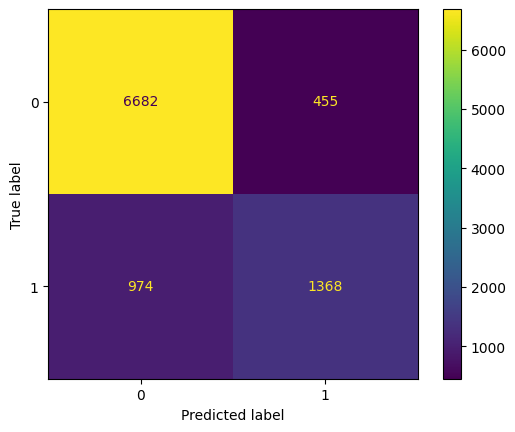

In [71]:
# 3. Test the model 
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Make predictions on the training data
    y_train_pred = model(X_train_tensor)
    
    # Convert the predictions to probabilities using the sigmoid function
    probabilities_train = torch.sigmoid(y_train_pred)
    predictions_train = (probabilities_train > 0.5).float()  # Convert to binary predictions (0 or 1)
    
    # Calculate accuracy for training data
    predictions_train_np = predictions_train.numpy()
    Y_train_np = Y_train_tensor.numpy()
    train_accuracy = accuracy_score(Y_train_np, predictions_train_np)
    print(f"Training Accuracy: {train_accuracy:.4f}")
    
    # Make predictions on the test data
    y_test_pred = model(X_test_tensor)
    
    # Convert the predictions to probabilities using the sigmoid function
    probabilities_test = torch.sigmoid(y_test_pred)
    predictions_test = (probabilities_test > 0.5).float()  # Convert to binary predictions (0 or 1)

    # Calculate accuracy for test data
    predictions_test_np = predictions_test.numpy()
    Y_test_np = Y_test_tensor.numpy()
    test_accuracy = accuracy_score(Y_test_np, predictions_test_np)
    print(f"Test Accuracy: {test_accuracy:.4f}")

     # Compute the test loss
    test_loss = criterion(y_test_pred, Y_test_tensor)
    print(f"Test Loss: {test_loss.item()}")

    # Compute confusion matrix for test data
    cm = confusion_matrix(Y_test_np, predictions_test_np)
    ConfusionMatrixDisplay(cm).plot()


## 5. Find a better model

In [94]:
# Define the model 

# 1. Original Model (Two Layer)
class FeedForward_Neural_Network(nn.Module):
    def __init__(self, input_size): 
        super(FeedForward_Neural_Network, self).__init__()

        # Define layers
        self.fhl_1 = nn.Linear(input_size, 64) # First hidden layer
        self.fhl_2 = nn.Linear(64, 64) # Second hidden layer
        self.out_layer = nn.Linear(64, 1) # Output layer 

    def forward(self, x): 
        x = torch.relu(self.fhl_1(x))
        x = torch.relu(self.fhl_2(x))
        x = self.out_layer(x)
        return x

model = FeedForward_Neural_Network(X_train_tensor.shape[1]) # Instantitate the model 


# 2. Model with Dropout (the rest is identical) 

## Define the model 
class FeedForward_Neural_Network_Dropout(nn.Module):
    def __init__(self, input_size): 
        super(FeedForward_Neural_Network_Dropout, self).__init__()

        # Define layers
        self.fhl_1 = nn.Linear(input_size, 64)  # First hidden layer
        self.dropout = nn.Dropout(p=0.5)        # Dropout layer
        self.out_layer = nn.Linear(64, 1)       # Output layer 

    def forward(self, x): 
        x = torch.relu(self.fhl_1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.out_layer(x)
        return x

model_dropout = FeedForward_Neural_Network_Dropout(X_train_tensor.shape[1]) # Instantiate the model 


# 3. Model with Dropout and one layer less (the rest is identical) 

class FeedForward_Neural_Network_One_Layer_Dropout(nn.Module):
    def __init__(self, input_size): 
        super(FeedForward_Neural_Network_One_Layer_Dropout, self).__init__()

        # Define layers
        self.fhl_1 = nn.Linear(input_size, 64)  # Single hidden layer
        self.dropout = nn.Dropout(p=0.5)        # Dropout layer
        self.out_layer = nn.Linear(64, 1)       # Output layer 

    def forward(self, x): 
        x = torch.relu(self.fhl_1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.out_layer(x)
        return x

model_dropout_one_layer = FeedForward_Neural_Network_One_Layer_Dropout(X_train_tensor.shape[1]) # Instantiate the model 


# 4. Model with one layer less

class FeedForward_Neural_Network_One_Layer(nn.Module):
    def __init__(self, input_size): 
        super(FeedForward_Neural_Network_One_Layer, self).__init__()

        # Define layers
        self.fhl_1 = nn.Linear(input_size, 64)  # Single hidden layer
        self.out_layer = nn.Linear(64, 1)       # Output layer 

    def forward(self, x): 
        x = torch.relu(self.fhl_1(x))
        x = self.out_layer(x)
        return x

model_one_layer = FeedForward_Neural_Network_One_Layer(X_train_tensor.shape[1]) # Instantiate the model 


# 5. Model with one layer more

class FeedForward_Neural_Network_One_Layer_More(nn.Module):
    def __init__(self, input_size): 
        super(FeedForward_Neural_Network_One_Layer_More, self).__init__()

        # Define layers
        self.fhl_1 = nn.Linear(input_size, 64)  # First hidden layer
        self.fhl_2 = nn.Linear(64, 64)          # Second hidden layer
        self.fhl_3 = nn.Linear(64, 64)          # New additional hidden layer
        self.out_layer = nn.Linear(64, 1)       # Output layer 

    def forward(self, x): 
        x = torch.relu(self.fhl_1(x))
        x = torch.relu(self.fhl_2(x))
        x = torch.relu(self.fhl_3(x))           # Apply new hidden layer
        x = self.out_layer(x)                   # Output layer
        return x

model_one_layer_more = FeedForward_Neural_Network_One_Layer_More(X_train_tensor.shape[1]) # Instantiate the model        

In [96]:
# Common loss function and optimizer 
criterion = nn.BCEWithLogitsLoss()  # (Automatically applies the sigmoid function)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [98]:
# Initialize a DataFrame to store the loss and accuracy information
metrics_df = pd.DataFrame(columns=['Model Name', 'Epoch Number', 'Loss Value', 'Accuracy', 'Epoch Time'])

# Define models
models = [
    ("Original Model", model),
    ("Model with Dropout", model_dropout),
    ("Model with Dropout & One Layer less", model_dropout_one_layer),
    ("Model with One Layer less", model_one_layer),
    ("Model with One Layer more", model_one_layer_more)
]

# Train each model
epochs = 25

for model_name, model in models:
    model.train()  # Set the model to training mode
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer for each model
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        start_time = time.time()  # Record time for the epoch
        
        # Iterate over batches
        for batch_idx, (data, target) in enumerate(train_loader):
            # Forward pass
            y_pred = model(data)
            
            # Compute the loss
            loss = criterion(y_pred, target)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()  # Add batch loss to the epoch loss
            
            # Calculate accuracy for the current batch
            probabilities = torch.sigmoid(y_pred)
            predictions = (probabilities > 0.5).float()  # Convert to binary predictions (0 or 1)
            accuracy = accuracy_score(target.numpy(), predictions.numpy())
            epoch_accuracy += accuracy
        
        epoch_loss /= len(train_loader)  # Average loss for the epoch
        epoch_accuracy /= len(train_loader)  # Average accuracy for the epoch

        # Calculate time for the epoch
        epoch_time = time.time() - start_time
        
        # Create a DataFrame for the current epoch's metrics
        epoch_metrics_df = pd.DataFrame({
            'Model Name': [model_name],
            'Epoch Number': [epoch],
            'Loss Value': [epoch_loss],
            'Accuracy': [epoch_accuracy],
            'Epoch Time': [epoch_time]
        })
        
        # Concatenate the new metrics to the main DataFrame
        metrics_df = pd.concat([metrics_df, epoch_metrics_df], ignore_index=True)
        
        # Print epoch metrics
        if epoch % 5 == 0:
            print(f"Epoch {epoch}/{epochs}, Model: {model_name}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}, Time: {epoch_time:.2f}s")


/var/folders/h2/p5_8w6zx0yj9mmfd194y3x840000gn/T/ipykernel_82948/504854446.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, epoch_metrics_df], ignore_index=True)


Epoch 0/25, Model: Original Model, Loss: 0.3409, Accuracy: 0.8402, LR: 0.001000, Time: 1.01s
Epoch 5/25, Model: Original Model, Loss: 0.2992, Accuracy: 0.8619, LR: 0.001000, Time: 1.19s
Epoch 10/25, Model: Original Model, Loss: 0.2907, Accuracy: 0.8649, LR: 0.001000, Time: 1.39s
Epoch 15/25, Model: Original Model, Loss: 0.2817, Accuracy: 0.8695, LR: 0.001000, Time: 0.95s
Epoch 20/25, Model: Original Model, Loss: 0.2735, Accuracy: 0.8730, LR: 0.001000, Time: 0.94s
Epoch 0/25, Model: Model with Dropout, Loss: 0.3662, Accuracy: 0.8298, LR: 0.001000, Time: 0.81s
Epoch 5/25, Model: Model with Dropout, Loss: 0.3176, Accuracy: 0.8538, LR: 0.001000, Time: 0.93s
Epoch 10/25, Model: Model with Dropout, Loss: 0.3125, Accuracy: 0.8562, LR: 0.001000, Time: 1.10s
Epoch 15/25, Model: Model with Dropout, Loss: 0.3090, Accuracy: 0.8582, LR: 0.001000, Time: 1.11s
Epoch 20/25, Model: Model with Dropout, Loss: 0.3100, Accuracy: 0.8579, LR: 0.001000, Time: 0.88s
Epoch 0/25, Model: Model with Dropout & One 

In [90]:
# Check dataframe
print(metrics_df.isna().sum())
metrics_df

Model Name      0
Epoch Number    0
Loss Value      0
Accuracy        0
Epoch Time      0
dtype: int64


,Model Name,Epoch Number,Loss Value,Accuracy,Epoch Time
0,Original Model,0,0.263197,0.878384,1.218638
1,Original Model,1,0.260521,0.877446,1.140032
2,Original Model,2,0.258120,0.879793,1.158498
3,Original Model,3,0.256203,0.880633,1.188406
4,Original Model,4,0.255618,0.881311,1.384878
...,...,...,...,...,...
120,Model with One Layer more,20,0.198935,0.908250,1.172989
121,Model with One Layer more,21,0.195767,0.909001,1.167555
122,Model with One Layer more,22,0.192510,0.909423,1.152617
123,Model with One Layer more,23,0.194389,0.907638,1.139395


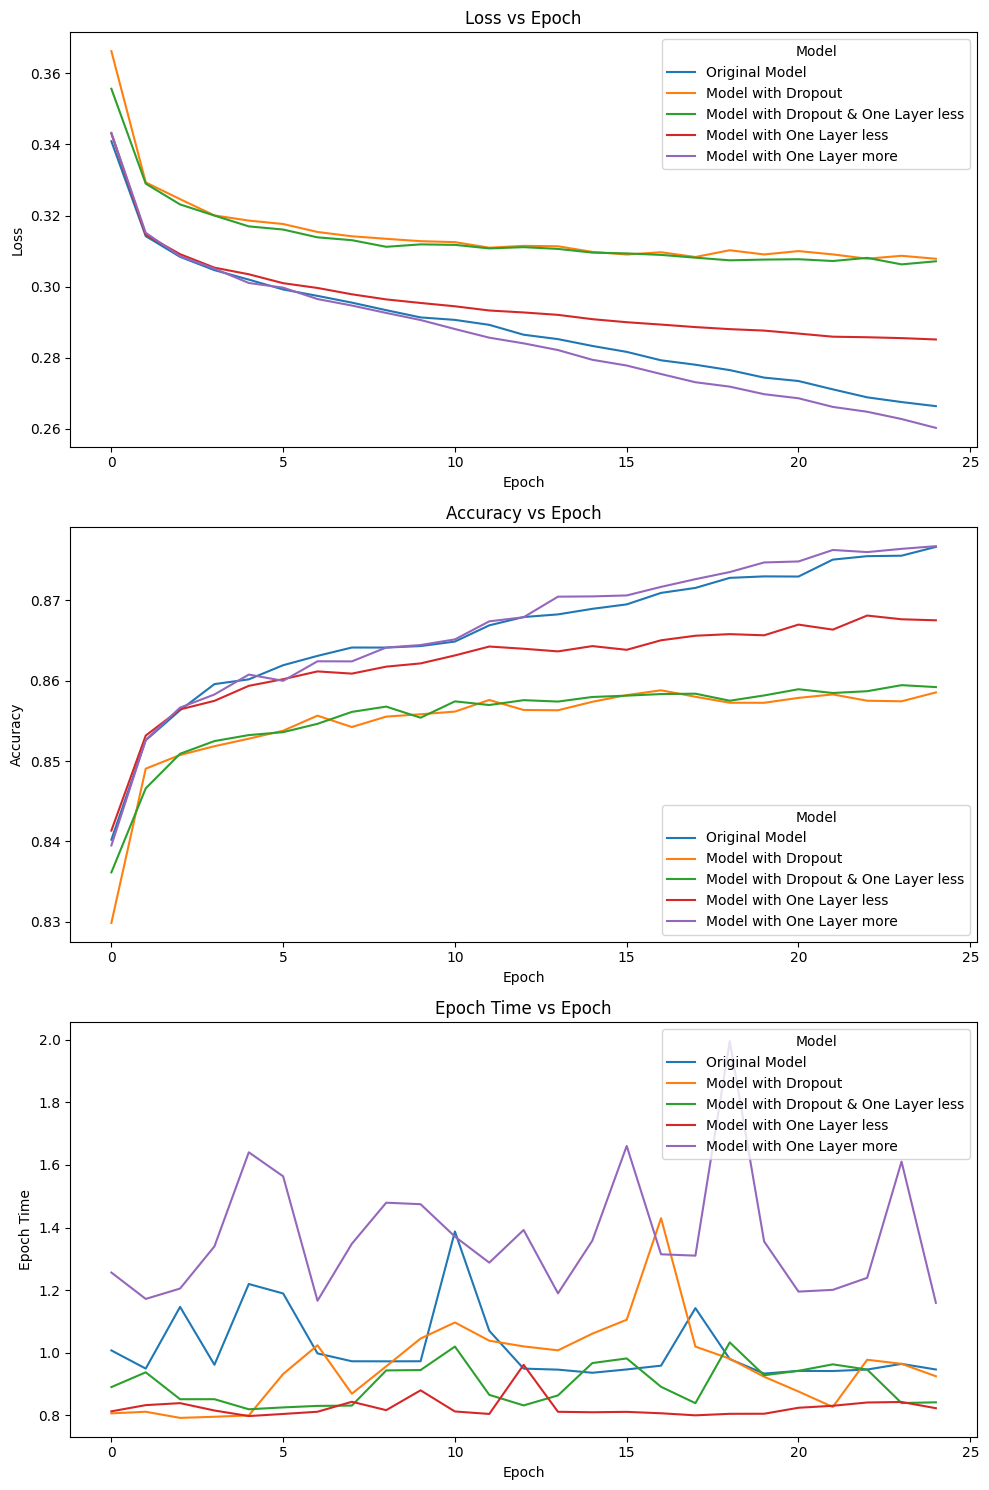

In [116]:
# Set up the plots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot Loss vs Epoch Number
for model_name in metrics_df['Model Name'].unique():
    model_data = metrics_df[metrics_df['Model Name'] == model_name]
    axes[0].plot(model_data['Epoch Number'], model_data['Loss Value'], label=model_name)
axes[0].set_title('Loss vs Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(title='Model')

# Plot Accuracy vs Epoch Number
for model_name in metrics_df['Model Name'].unique():
    model_data = metrics_df[metrics_df['Model Name'] == model_name]
    axes[1].plot(model_data['Epoch Number'], model_data['Accuracy'], label=model_name)
axes[1].set_title('Accuracy vs Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(title='Model')

# Plot Epoch Time vs Epoch
for model_name in metrics_df['Model Name'].unique():
    model_data = metrics_df[metrics_df['Model Name'] == model_name]
    axes[2].plot(model_data['Epoch Number'], model_data['Epoch Time'], label=model_name)
axes[2].set_title('Epoch Time vs Epoch')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Epoch Time')
axes[2].legend(title='Model')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [108]:
# Initialize a list to collect rows
rows = []

# Evaluate each model
for model_name, model in models:
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Forward pass
        y_test_pred = model(X_test_tensor)
        
        # Convert to probabilities
        probabilities = torch.sigmoid(y_test_pred)
        
        # Binary predictions
        predictions = (probabilities > 0.5).float()
        
        # Calculate confusion matrix
        cm = confusion_matrix(Y_test_tensor.numpy(), predictions.numpy())
        TN, FP, FN, TP = cm.ravel()  # Extract confusion matrix elements
        
        # Calculate metrics
        test_accuracy = accuracy_score(Y_test_tensor.numpy(), predictions.numpy())
        precision = precision_score(Y_test_tensor.numpy(), predictions.numpy())
        recall = recall_score(Y_test_tensor.numpy(), predictions.numpy())  # Sensitivity
        f1 = f1_score(Y_test_tensor.numpy(), predictions.numpy())
        roc_auc = roc_auc_score(Y_test_tensor.numpy(), probabilities.numpy())
        specificity = TN / (TN + FP)  # Specificity calculation
        balanced_accuracy = (recall + specificity) / 2  # Balanced Accuracy calculation
        
        # Append the row to the list
        rows.append({
            'Model Name': model_name,
            'Test Accuracy': test_accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc,
            'Specificity': specificity,
            'Balanced Accuracy': balanced_accuracy
        })

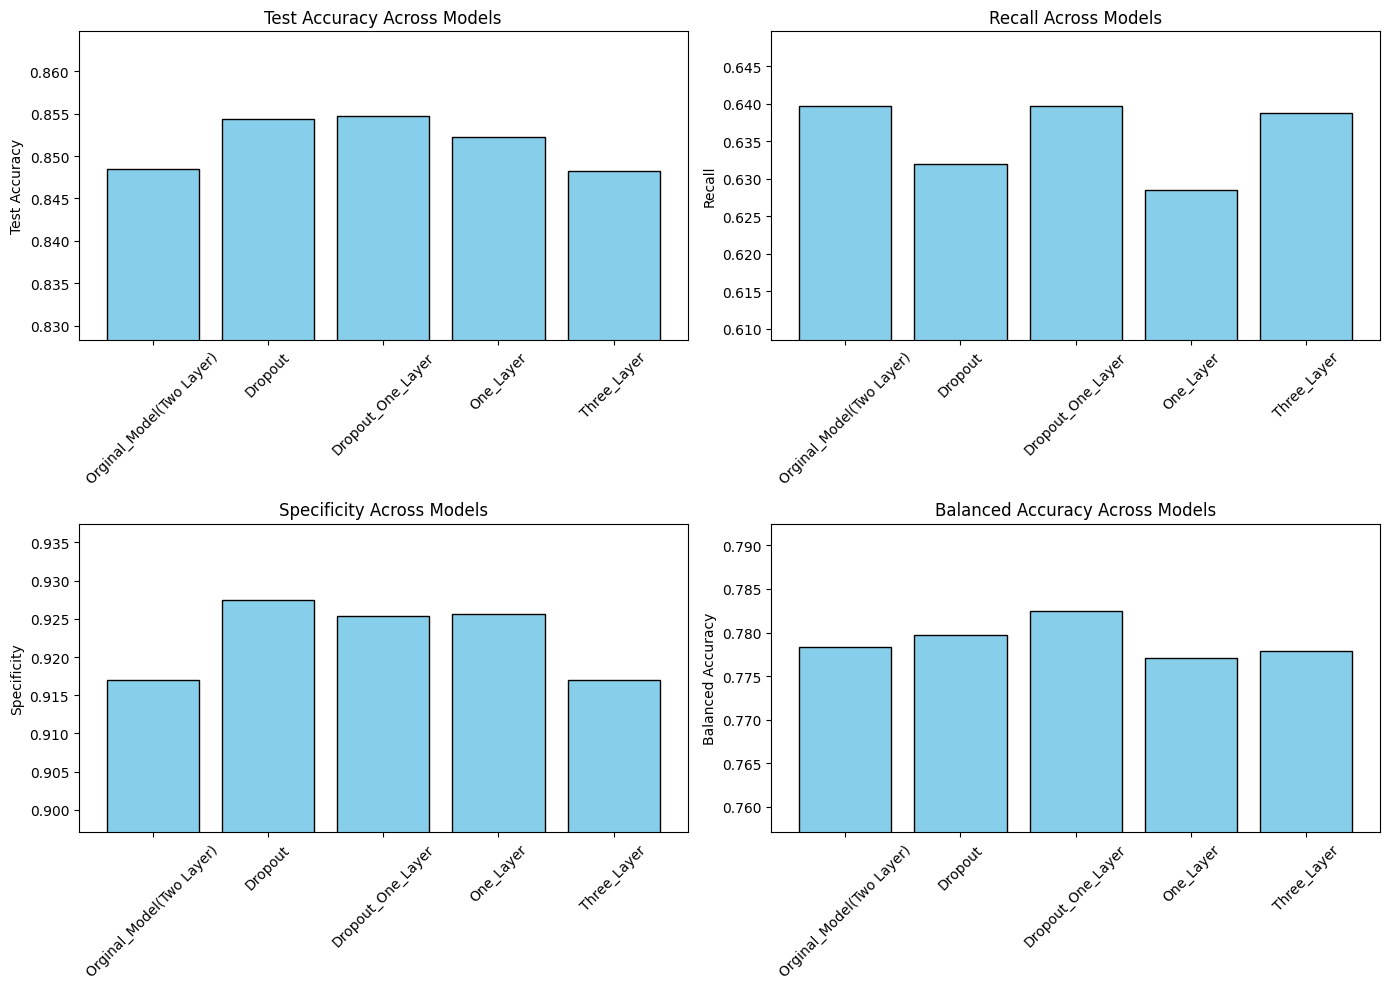

In [120]:
# Plot the results 
test_accuracy_df = pd.DataFrame(rows)
name_mapping = {
    'Original Model': 'Orginal_Model(Two Layer)',
    'Model with Dropout': 'Dropout',
    'Model with Dropout & One Layer less': 'Dropout_One_Layer',
    'Model with One Layer less': 'One_Layer',
    'Model with One Layer more': 'Three_Layer'
}
test_accuracy_df['Model Name'] = test_accuracy_df['Model Name'].map(name_mapping)

# Metrics to plot
metrics = ['Test Accuracy', 'Recall', 'Specificity', 'Balanced Accuracy']

# Create subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Iterate over metrics and axes
for ax, metric in zip(axes.flat, metrics):
    # Get the min and max values of the metric
    min_value = test_accuracy_df[metric].min()
    max_value = test_accuracy_df[metric].max()

    # Set the y-axis limits
    ymin = min_value - 0.02
    ymax = max_value + 0.01

    # Plot the bar chart
    ax.bar(test_accuracy_df['Model Name'], test_accuracy_df[metric], color='skyblue', edgecolor='black')
    ax.set_title(f'{metric} Across Models')
    ax.set_ylabel(metric)
    ax.set_ylim(ymin, ymax)  # Adjust y-axis limits dynamically

    # Set ticks and labels for rotated x-axis
    ax.set_xticks(range(len(test_accuracy_df['Model Name'])))
    ax.set_xticklabels(test_accuracy_df['Model Name'], rotation=45)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()
